# Gender classification by transaction

In this project, we will go thourgh the [shopping session data](https://github.com/andynganle/Data-for-Assignment) where each row contains the information of a session : session id, session's start time, session's end time, products purchased and the gender of the user in that session.

After that, an attemp to perform a gender classification for users based on their sessions's information will be demonstrated.

## Preprocessing data

Firstly, we need import necessary packages, read the data from files and see some general information.

In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [580]:
features = pd.read_csv('trainingData.csv', header=None, names=['session_id', 'session_start', 'session_end', 'products'])
labels = pd.read_csv('trainingLabels.csv', header=None, names=['gender'])

In [581]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
session_id       15000 non-null object
session_start    15000 non-null object
session_end      15000 non-null object
products         15000 non-null object
dtypes: object(4)
memory usage: 468.8+ KB


In [582]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 1 columns):
gender    15000 non-null object
dtypes: object(1)
memory usage: 117.3+ KB


In [583]:
features.head()

,session_id,session_start,session_end,products
0,u10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/
1,u10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/
2,u10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...
3,u10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/
4,u10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...


In [584]:
labels.head()

,gender
0,female
1,female
2,female
3,female
4,female


A session's start time and end time are date time but they are stored as string. Therefore, the columns 'session_start' and 'session_end' need to be converted to datetime columns so that they can be used later for calculations.

In [585]:
features.session_start = pd.to_datetime(features.session_start)
features.session_end = pd.to_datetime(features.session_end)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
session_id       15000 non-null object
session_start    15000 non-null datetime64[ns]
session_end      15000 non-null datetime64[ns]
products         15000 non-null object
dtypes: datetime64[ns](2), object(2)
memory usage: 468.8+ KB


The time spent for each session can be an interesting feature for the classification. A session's time is the difference between the session's start time and end time. The unit for this feature is number of minutes.

In [586]:
features['session_time'] = np.round((features.session_end - features.session_start).astype('timedelta64[s]') / 60)
features['session_time'].describe()

count    15000.000000
mean       130.303200
std       1880.787696
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      50753.000000
Name: session_time, dtype: float64

The descriptive statistics of the 'session_time' column shows that most sessions (75%) lasted 2 minutes or less. It does contain unusual values like 50753 (max) which is equal to 35 days. This needs to be investigated and fixed if necessary. However, we leave the column as it is for the classification.

The hours of a session's start time and end time can also be valuable features as the number of visitors is usually not the same at different times of day.

In [587]:
features['start_hour'] = features['session_start'].dt.hour
features['end_hour'] = features['session_end'].dt.hour

Now, we have 3 new features 'session_time', 'session_start' and 'session_end'. Next, we will plot the values of these features for each gender to see if there are differences. If a feature's values are different between genders, then it means that the feature can be used for the classification.

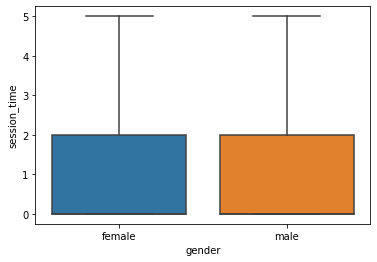

In [588]:
import seaborn as sns

merge = features.merge(labels, left_index=True, right_index=True)
sns.boxplot(x='gender', y='session_time',data=merge, showfliers=False)

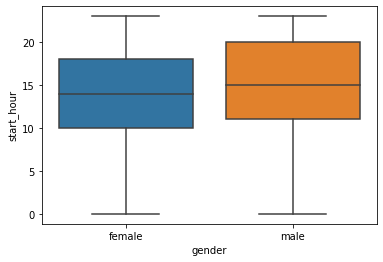

In [589]:
sns.boxplot(x='gender', y='start_hour',data=merge, showfliers=False)

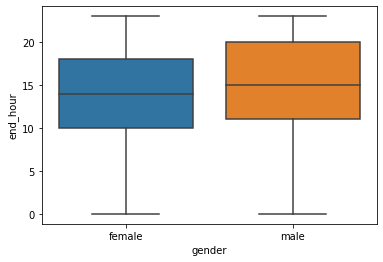

In [590]:
sns.boxplot(x='gender', y='end_hour',data=merge, showfliers=False)

As shown in the three figures above, there is no clear difference between male and female for session time, start hour and end hour. Therefore, these features are excluded in the classification.

Next, we process the 'products' column, which contains the list of ordered products in each session.

In [591]:
product_col = merge.products.values
product_col[:10]

array(['A00001/B00001/C00001/D00001/', 'A00002/B00002/C00002/D24897/',
       'A00002/B00002/C00002/D00002/;A00002/B00002/C00003/D00003/;A00002/B00002/C00007/D00007/;A00002/B00002/C00002/D00009/;A00002/B00002/C00003/D00010/;A00002/B00002/C00007/D00011/;A00002/B00002/C00002/D00012/;A00002/B00002/C00007/D00014/;A00002/B00002/C00003/D00017/;A00002/B00002/C00011/D00021/;A00002/B00002/C00004/D00023/;A00002/B00002/C00012/D00025/',
       'A00002/B00006/C00015/D00030/',
       'A00002/B00002/C00003/D00033/;A00002/B00002/C00007/D00035/;A00002/B00002/C00007/D00038/',
       'A00002/B00007/C00016/D00836/',
       'A00002/B00006/C00030/D05969/;A00002/B00006/C00030/D05970/;A00002/B00006/C00030/D05971/;A00002/B00006/C00030/D05972/;A00002/B00006/C00030/D05974/;A00002/B00006/C00030/D05976/',
       'A00002/B00006/C00030/D05978/;A00002/B00006/C00015/D05980/',
       'A00002/B00002/C00002/D06873/', 'A00002/B00011/C00180/D14591/'],
      dtype=object)

Since in a shopping session, any number of orders is accepted, each row of the 'products' columns can contain any number of values. This is invalid in machine learning, where each variable of an observation contains one value. The column needs to be transformed. 

For each product ordered, we know which category, sub-category (A, B, C, D) that the product belongs to. In my opinion, we can use this information to classify users' genders. My approach is to transform the 'products' column into boolean columns of categories and sub-categories. So, for categories of type A, we have columns 'A00001', 'A00002',... . For categories of type B, there are columns 'A00001/B00001', 'A00002/B00002',... . For each session ( row ), if a product of a category, sub-category is ordered, then the values in the columns that represent those category, sub-category are 'True', otherwise, the values are 'False'. For example, if in a session, the user orders a product 'A00001/B00001/C00001/D00001/', then values for the columns 'A00001', 'A00001/B00001' and 'A00001/B00001/C00001' are 'True', the value for the column 'A00002' is 'False' because there is no ordered product in that category.     

**Remark:** In each sub-category's label, the label of higher level categories also need to be included, otherwise, the sub-category 'B00001' of 'A00001' will be treated as 'B00001' of 'A00002' ( same labels but different parent categories ).

Firstly, we need to find categories, sub-categories of the ordered products in each session. We do not care about product labels because the number of unique products is too high, which could lead to very high dimensional data, while most of the products are ordered once or twice. Therefore, product labels do not help with the classification. 

In [592]:
orders = []
for row in product_col:
    orders.extend(row.split(';'))
len(orders)

33455

There are 33455 products ordered from 15000 shopping sessions

In [593]:
products, counts = np.unique(purchased, return_counts=True)
catalogue = dict(zip(products, counts))
len(catalogue)

21888

The number of unique products ordered is 21888, much larger than the number of sessions. 

For each session, we every category A that the ordered products belong to and store them in the variable A. A is a list of sets so that each category is included once for each session even if there are many products of that category ordered in that session. Also, it is efficient when filling new columns with values, checking if a category or a sub-category exists in a session is O(1). 

In [594]:
A = [set([product.split('/')[0] for product in row.split(';')]) for row in product_col]
A[:10]

[{'A00001'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'},
 {'A00002'}]

Likewise, we find every B category for each session...

In [595]:
B = [set(['/'.join(product.split('/')[:2]) for product in row.split(';')]) for row in product_col]
B[:10]

[{'A00001/B00001'},
 {'A00002/B00002'},
 {'A00002/B00002'},
 {'A00002/B00006'},
 {'A00002/B00002'},
 {'A00002/B00007'},
 {'A00002/B00006'},
 {'A00002/B00006'},
 {'A00002/B00002'},
 {'A00002/B00011'}]

and then every C for each session.

In [596]:
C = [set(['/'.join(product.split('/')[:3]) for product in row.split(';')]) for row in product_col]
C[:10]

[{'A00001/B00001/C00001'},
 {'A00002/B00002/C00002'},
 {'A00002/B00002/C00002',
  'A00002/B00002/C00003',
  'A00002/B00002/C00004',
  'A00002/B00002/C00007',
  'A00002/B00002/C00011',
  'A00002/B00002/C00012'},
 {'A00002/B00006/C00015'},
 {'A00002/B00002/C00003', 'A00002/B00002/C00007'},
 {'A00002/B00007/C00016'},
 {'A00002/B00006/C00030'},
 {'A00002/B00006/C00015', 'A00002/B00006/C00030'},
 {'A00002/B00002/C00002'},
 {'A00002/B00011/C00180'}]

After that, we find every possible label for A, B, C categories, which are new features for the input data. 

In [597]:
unique_A = set().union(*A)
unique_A

{'A00001',
 'A00002',
 'A00003',
 'A00004',
 'A00005',
 'A00006',
 'A00007',
 'A00008',
 'A00009',
 'A00010',
 'A00011'}

In [598]:
unique_B = set().union(*B)
unique_C = set().union(*C)

Then, we compute the values for the new columns in each session.

In [599]:
A_cols = list(unique_A)
A_values = [[(cat in row) for cat in A_cols] for row in A]
A_values[:10]

[[False, True, False, False, False, False, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False],
 [False, False, False, False, False, True, False, False, False, False, False]]

In [600]:
B_cols = list(unique_B)
B_values = [[(cat in row) for cat in B_cols] for row in B]

C_cols = list(unique_C)
C_values = [[(cat in row) for cat in C_cols] for row in C]

Then, from those 2D arrays, we create dataframtes which contain the new columns with correspoding values for the sessions. These dataframes will be merged together to create the input data for the classification model.

In [601]:
A_features = pd.DataFrame(A_values, columns=A_cols)
A_features.head()

,A00005,A00001,A00007,A00010,A00003,A00002,A00004,A00011,A00008,A00009,A00006
0,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False


In [602]:
B_features = pd.DataFrame(B_values, columns=B_cols)
C_features = pd.DataFrame(C_values, columns=C_cols)

The input data X is created by merging the new dataframes.

In [603]:
X = A_features.merge(B_features, left_index=True, right_index=True).merge(C_features, left_index=True, right_index=True)
X.head()

,A00005,A00001,A00007,A00010,A00003,A00002,A00004,A00011,A00008,A00009,...,A00001/B00004/C00066,A00003/B00035/C00107,A00001/B00015/C00041,A00011/B00056/C00169,A00001/B00027/C00275,A00011/B00056/C00299,A00002/B00004/C00154,A00010/B00069/C00246,A00002/B00005/C00013,A00002/B00005/C00058
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The target data y is the gender column. It need to be converted to boolean. If the gender is 'male', then the value is 'True', otherwise 'False'.

In [604]:
y = (merge.gender == 'male') 
y.head()

0    False
1    False
2    False
3    False
4    False
Name: gender, dtype: bool

## Classification

As all the features are boolean and the classification is binary, in my opinion, the best model for the classification is Decision Tree or its variants like Random Forest. 

A Decision Tree is trained by going through the shopping data and asking whether the ordered products belongs to a category or a sub-category to perform the classification. If a category or a sub-category can well seperate male and female users ( spliting into new nodes that have the least impurities ), then it is chosen to split the data. The subsets of the data then go to the next questions for other (sub-)categories until no splitting improvement can be observed. In the end, the data is splitted into multiple subsets and contained in the leaf nodes of the Decision Tree, each leaf node represents the dominated class ( male or female ) of the contained subset.  

Later, the tree can classify a session by asking the same sets of questions to that session, the session will travel from one question ( node ) to another until reaching leaf node, the class ( male or female ) of session is decided by the class of the leaf node.

A Random Forest is an ensemble learning method, which is composed of multiple trees and each tree is trained with a sample from the original training data. After the training, an input data is classified going through each tree in the Random Forest. The class of data is the class returned by most of the trees. 

We will test this two models for the shopping data.

In [605]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

We split the data into two subsets, one for training and the other for testing ( ratio 2:1 ), the two subsets will have the same proportion for each class ( stratify=y ).

In [606]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

We create a Decision Tree and fit the training data.

In [607]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Then we use the trained tree to perform a classification on test data, computing the confusion matrix.

In [608]:
y_pred = tree.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(3613, 249, 471, 617)

The positive class represents 'male' and the negative one is 'female'. Therefore, tp is the number of correctly classified males, tn is number of correctly classified females, fp is the number of females classified as males, fn is the number of males classified as females.

In [609]:
male_correct = tp
male_total = tp + fn
male_correct / male_total

0.5670955882352942

In [610]:
female_correct = tn
female_total = tn + fp
female_correct / female_total

0.9355256343863283

In [611]:
Score = (male_correct / male_total + female_correct / female_total) / 2
Score

0.7513106113108112

With Decision Tree, more than 56% of males and 93% of females are correctly classified. The overall score for this model is 0.751.

Next we will train a Random Forest to see if there is any improvement.

In [612]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [613]:
y_pred = forest.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(3641, 221, 464, 624)

In [614]:
male_correct = tp
male_total = tp + fn
male_correct / male_total

0.5735294117647058

In [615]:
female_correct = tn
female_total = tn + fp
female_correct / female_total

0.9427757638529259

In [616]:
Score = (male_correct / male_total + female_correct / female_total) / 2
Score

0.7581525878088159

With Random Forest, the result is slightly better. More than 57% of males and 94% of females are correctly classified, the overall score is 0.758.

However, there is still a significant difference when classifying male and female users ( 57% vs 94% ). This is because that there are more sessions created by females than males.

In [617]:
female_total / male_total

3.5496323529411766

Female users are about 3.5 times more than male users. One way to tackle this problem is to undersample the female class. We perform it on the training data, 60% of female data will be used to train the model.

In [620]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

In [621]:
Xy = X_train.merge(y_train, left_index=True, right_index=True)
Xy_male = Xy[Xy.gender == True]
Xy_female = Xy[Xy.gender == False]
Xy = pd.concat([Xy_female.sample(frac=0.6, random_state=1), Xy_male], ignore_index=True)

X_train = Xy.drop(['gender'], axis=1)
y_train = Xy.gender

Then we use the undersampled data to train a new Random Forest to see if the result is better.

In [622]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [623]:
y_pred = forest.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(3572, 290, 417, 671)

In [624]:
male_correct = tp
male_total = tp + fn
male_correct / male_total

0.6167279411764706

In [625]:
female_correct = tn
female_total = tn + fp
female_correct / female_total

0.9249093733816676

In [626]:
Score = (male_correct / male_total + female_correct / female_total) / 2
Score

0.7708186572790691

After the undersampling, the percentage of males correctly classified increases from 57% to more than 61% whereas the percentage for females decreases from 94% to 92%. The score slightly increases from 0.758 to 0.771. 